In [1]:
!wget -cq https://github.com/ynadji/hands-on-adversarial-ml/raw/colab/data/01-monotonic-classifiers/benign-traces.tar.gz
!wget -cq https://github.com/ynadji/hands-on-adversarial-ml/raw/colab/data/01-monotonic-classifiers/malicious-traces.tar.gz
!wget -cq https://github.com/ynadji/hands-on-adversarial-ml/raw/colab/data/01-monotonic-classifiers/feature-vectors.tar.gz
!for x in *.tar.gz; do tar xzf ${x}; done

# Monotonic Classifiers

Some classifiers should never "flip-flop" between classes. For example, consider the following classifier that labels system call traces from programs as being benign or malicious programs. No matter how many benign instructions are added to a malicious program, it should never trick the classifier into thinking it is benign.

The classifier below takes sequences of system calls obtained from execution traces from malicious and benign programs. Treating each execution trace as a document, we extract a tf-idf[1] vector for feature extraction. Code below is provided that:
1. Grabs ground truth traces
1. Vectorizes them with tf-idf
1. Performs 10-fold cross validation
1. Trains a Logistic Regression model

Your task as a malware author yourself, is to find direct and indirect ways to break this model so antivirus software cannot detect your code. Approach these tasks in three chunks:
1. Manually manipulate a malicious feature vector such that the classifier mistakenly labels it malicious. If you successfully do this once, create a function that given a benign feature vector returns a new one that will be classified as benign.
1. Identify features that, given your knowledge of what monotonic classifiers try to solve, could be used to "flip" a malicious program into benign one.
1. Using the aforementioned features, write a function that transforms a malicious syscall trace (appending is fine) to be classified as benign.
1. Modify the classifier so these features can no longer be used to "flip" a malicious trace. There's a quick'n'dirty way to do this, but more sophisticated[2] and robust[3] techniques exist if monotonicity is an important feature that your classifier needs.

## References
* [1] https://en.wikipedia.org/wiki/Tf%E2%80%93idf
* [2] https://arxiv.org/pdf/1804.03643.pdf
* [3] https://www.slideshare.net/MSbluehat/bluehat-v17-detecting-compromise-on-windows-endpoints-with-osquery

## Utility Functions

In [2]:
import os
import sys
import fnmatch
import random
import itertools
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
import joblib
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

## utils
def rwalk(directory, pattern):
    """Recursively search "directory" for files that match the Unix shell-style
    wildcard given by "pattern" (like '*.mp3'). Returns matches as a generator."""
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            yield os.path.join(root, filename)

def gettraces(benignpath='benign-traces',
              malpath='malicious-traces'):
    return list(rwalk(malpath, '*.trace')), list(rwalk(benignpath, '*.trace'))

def get_random_malicious_trace(malpath='malicious-traces'):
    """Grab the text of a random malicious system call trace."""
    mal, _ = gettraces(malpath=malpath)
    with open(random.choice(mal)) as f:
        return f.read()

## Use the TfidfVectorizer to vectorize ground truth

The following extracts vectors from each benign and malicious execution trace and returns four values:
1. `X`: the feature vectors
1. `y`: the class labels
1. `terms`: the list of labels (0 is benign, 1 is malicious)
1. `vectorizer`: a TfidfVectorizer which is fit to the terms in the ground truth and can be used to fit new syscall traces with `vectorizer.transform([trace1, trace2, ..., traceN])`

In [3]:
def vectorize(featuredir='feature-vectors'):
    pos_traces, neg_traces = gettraces()
    pos_y = [1 for _ in pos_traces]
    neg_y = [0 for _ in neg_traces]
    docs = [open(x).read() for x in pos_traces + neg_traces]
    y = np.array(pos_y + neg_y)

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(docs)
    terms = np.asarray(vectorizer.get_feature_names_out())
    return X, y, terms, vectorizer

X, y, terms, vectorizer = vectorize()

In [4]:
X

<2000x16 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

In [5]:
terms

array(['ntcreateprocessex', 'ntcreatethreadex', 'ntcreateuserprocess',
       'ntdisplaystring', 'ntdrawtext', 'ntmodifybootentry', 'ntopenfile',
       'ntopenkeyex', 'ntopentimer', 'ntquerydirectoryfile', 'ntreadfile',
       'ntsavekeyex', 'ntsettimerex', 'ntwritefile', 'regcreatekeyex',
       'regsavekeyex'], dtype=object)

In [6]:
def _heatmap(crosstab):
    plt.clf()
    p = seaborn.heatmap(crosstab, square=True)
    plt.tight_layout()
    plt.show()

def _cv(X, y, k, name, clf, csvname, modeldir=None, terms=None, resultdir=None):
    print('## %s' % name)
    print('### Cross Validation')
    print('`%s`' % str(cross_val_score(clf, X, y, cv=k)))
    print('### CV Confusion Matrix')
    y_pred = cross_val_predict(clf, X, y, cv=k)
    print('```')
    print(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted']))
    print('```')
    _heatmap(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'],
                         normalize='index'))
    clf.fit(X, y)
    return clf

## name
### Cross Validation
`[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]`
### CV Confusion Matrix
```
Predicted     0     1
True                 
0          1000     0
1             0  1000
```


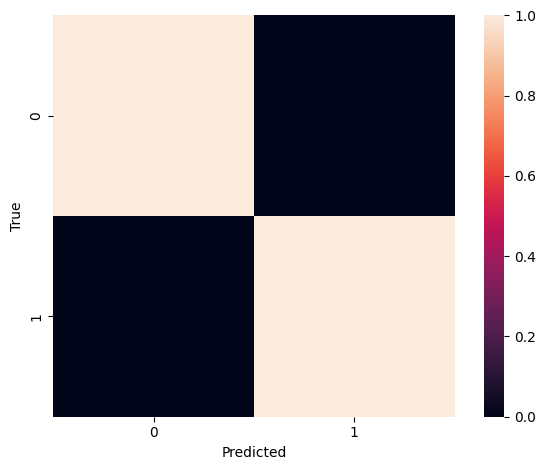

In [7]:
clf = _cv(X, y, 10, 'name', LogisticRegression(solver='lbfgs'), 'foo.csv', modeldir='../work', terms=terms, resultdir='../work')

In [8]:
clf.classes_

array([0, 1])

In [9]:
clf.coef_[0]

array([ 2.24482262,  2.24424061, -2.14186277, -2.13967196, -2.1405273 ,
        2.24523331, -2.13965475, -2.13854639, -2.13845327, -2.1407568 ,
       -2.14462209,  2.24613296,  2.24276795,  0.10771154,  2.24801507,
        2.2431061 ])

In [10]:
terms

array(['ntcreateprocessex', 'ntcreatethreadex', 'ntcreateuserprocess',
       'ntdisplaystring', 'ntdrawtext', 'ntmodifybootentry', 'ntopenfile',
       'ntopenkeyex', 'ntopentimer', 'ntquerydirectoryfile', 'ntreadfile',
       'ntsavekeyex', 'ntsettimerex', 'ntwritefile', 'regcreatekeyex',
       'regsavekeyex'], dtype=object)

# Exploration

Let's spend some time familiarizing ourselves with the input data and the classifier. First, we'll examine the dataset in more detail. Then, we'll go over how to interact with the classifier through the vectorizer and `numpy`.

## Dataset

In [11]:
# Load all malicious and benign traces from the ground truth dataset
maltraces, bentraces = gettraces()
print('num malicious traces: %d' % len(maltraces))
print('num benign traces: %d' % len(bentraces))
print('malicious trace path: %s' % maltraces[0])
print('benign trace path: %s' % bentraces[0])

# Let's see what a trace file looks like!
with open(maltraces[0]) as f:
    maltrace = f.read()

print('\n# Sample Trace')
print(maltrace[:100] + '...')
print('len(trace): %d' % len(maltrace))
# i/o basics
# numpy basics
# classifier basics

num malicious traces: 1000
num benign traces: 1000
malicious trace path: malicious-traces/0920.trace
benign trace path: benign-traces/0920.trace

# Sample Trace
NtCreateProcessEx
NtCreateProcessEx
NtSaveKeyEx
NtWriteFile
NtCreateThreadEx
RegCreateKeyEx
NtWriteF...
len(trace): 402616


So we have 1000 malicious and 1000 benign traces, which are simple text files. The traces files contain one [win32 API call](https://docs.microsoft.com/en-us/windows/win32/api/winreg/nf-winreg-regcreatekeyexa) per line. What is the distribution of system calls in this single malicious trace we've been analyzing?

In [12]:
def frequency(trace):
    return Counter(trace.splitlines())
frequency(maltrace).most_common()

[('NtWriteFile', 3379),
 ('NtCreateProcessEx', 3120),
 ('NtCreateThreadEx', 3118),
 ('NtSetTimerEx', 3099),
 ('NtModifyBootEntry', 3082),
 ('NtSaveKeyEx', 3071),
 ('RegCreateKeyEx', 3065),
 ('RegSaveKeyEx', 3034),
 ('NtReadFile', 339),
 ('NtOpenTimer', 319),
 ('NtDrawText', 318),
 ('NtQueryDirectoryFile', 304),
 ('NtCreateUserProcess', 303),
 ('NtOpenKeyEx', 301),
 ('NtDisplayString', 300),
 ('NtOpenFile', 269)]

And for a single benign trace?

In [13]:
with open(bentraces[0]) as f:
    bentrace = f.read()

frequency(bentrace).most_common()

[('NtWriteFile', 784),
 ('NtOpenTimer', 765),
 ('NtOpenFile', 731),
 ('NtDisplayString', 724),
 ('NtOpenKeyEx', 695),
 ('NtCreateUserProcess', 691),
 ('NtDrawText', 685),
 ('NtQueryDirectoryFile', 683),
 ('NtReadFile', 682),
 ('NtSaveKeyEx', 102),
 ('NtCreateThreadEx', 97),
 ('RegCreateKeyEx', 85),
 ('NtModifyBootEntry', 82),
 ('NtCreateProcessEx', 81),
 ('NtSetTimerEx', 77),
 ('RegSaveKeyEx', 73)]

What are some of the differences between these two traces? Post your answers in Group Chat!

The `Counter` class let's us add two of them together to merge the counts. For example:

In [14]:
(frequency(maltrace) + frequency(bentrace)).most_common()

[('NtWriteFile', 4163),
 ('NtCreateThreadEx', 3215),
 ('NtCreateProcessEx', 3201),
 ('NtSetTimerEx', 3176),
 ('NtSaveKeyEx', 3173),
 ('NtModifyBootEntry', 3164),
 ('RegCreateKeyEx', 3150),
 ('RegSaveKeyEx', 3107),
 ('NtOpenTimer', 1084),
 ('NtDisplayString', 1024),
 ('NtReadFile', 1021),
 ('NtDrawText', 1003),
 ('NtOpenFile', 1000),
 ('NtOpenKeyEx', 996),
 ('NtCreateUserProcess', 994),
 ('NtQueryDirectoryFile', 987)]

## Vectorizer, Numpy, and Classifier

This particular classifier relies on a `vectorizer` that turns raw text---like our traces---into a numerical feature vector. This allows us to use our typical machine learning algorithms on text data. Let's create a matrix containing two feature vectors containing the malicious and benign traces from above.

In [15]:
A = vectorizer.transform([maltrace, bentrace])
print(A.shape)

A.todense()

(2, 16)


matrix([[0.3515576 , 0.35133224, 0.03414165, 0.03380362, 0.03583183,
         0.34727581, 0.03031057, 0.03391629, 0.03594451, 0.03425433,
         0.03819809, 0.34603634, 0.34919134, 0.38074139, 0.34536027,
         0.34186723],
        [0.03747694, 0.04487979, 0.3197107 , 0.33497908, 0.31693463,
         0.03793962, 0.33821783, 0.32156141, 0.35394889, 0.31600927,
         0.31554659, 0.04719319, 0.03562623, 0.36273978, 0.03932765,
         0.03377552]])

So we see that `vectorizer.transform` takes a list of traces (the raw text from the file, _not_ the path) as input and returns a matrix of values where each row corresponds to the trace and the columns represent the vectorized text, i.e., our features. This means our dataset contains 16 features.

Since we now have a matrix of values, we can do simple matrix arithmetic to manipulate the feature vectors. For those not familiar with the library `numpy` (here `import numpy as np`), we can construct `n`-dimensional arrays with `np.array`. For example:

In [16]:
a = np.array(range(16))
print(a.shape)
print(a)

(16,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Creates a 1-dimensional array (a vector) of the values 0--15. We can now do vectorized arithmetic to affect all the values in a matrix without having to waste time looping through each row. For example, the snippet below adds 1 to every other column in the feature vector matrix.

In [17]:
A + np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

matrix([[1.3515576 , 0.35133224, 1.03414165, 0.03380362, 1.03583183,
         0.34727581, 1.03031057, 0.03391629, 1.03594451, 0.03425433,
         1.03819809, 0.34603634, 1.34919134, 0.38074139, 1.34536027,
         0.34186723],
        [1.03747694, 0.04487979, 1.3197107 , 0.33497908, 1.31693463,
         0.03793962, 1.33821783, 0.32156141, 1.35394889, 0.31600927,
         1.31554659, 0.04719319, 1.03562623, 0.36273978, 1.03932765,
         0.03377552]])

So now that we have a matrix, how do we use the classifier? Our classifier was built above and stored as `clf`. We can use the `clf.predict()` method to predict whether a vectorized trace is from a malicious or benign program. Note that `1` means malicious and `0` means benign.

In [18]:
clf.predict(A)

array([1, 0])

This means our first row was classified as malicious and our second row was classified as benign. Considering `A` was constructed by running `vectorizer.transform([maltrace, bentrace])`, this makes perfect sense! Since `A` is just a matrix of values, we can also classify the manipulation of these matrices as we had done above. For example, let's add a vector to `A` and see how it impacts the classifier's output:

In [25]:
clf.predict(np.asarray(A.todense()) + np.array(range(16)))

array([1, 1])

Notice that this affected the classification result! Both are now considered malicious. Soon, we'll figure out how to do this in the other direction :). But first...

# Warm Up

Complete the following exercises to demonstrate familiarity with the dataset:

* How many _unique_ system calls are there in this dataset in total?
* What is the most common system call? For malicious traces only? What about benign?
* Complete the function `get_feature_vector(path, vectorizer)` that given a path to a trace and the example vectorizer, returns the feature vector as a matrix.

Post your answers to the Group Chat!

In [21]:
# TODO: delete
mal_counts = Counter()
for path in maltraces:
    with open(path) as f:
        trace = f.read()
        mal_counts += frequency(trace)

ben_counts = Counter()
for path in bentraces:
    with open(path) as f:
        trace = f.read()
        ben_counts += frequency(trace)

all_counts = mal_counts + ben_counts

print('# system calls: %d' % len(all_counts))
print('most common (all):', all_counts.most_common()[0])
print('most common (mal):', mal_counts.most_common()[0])
print('most common (ben):', ben_counts.most_common()[0])

print('least common (all):', all_counts.most_common()[-1])
print('least common (mal):', mal_counts.most_common()[-1])
print('least common (ben):', ben_counts.most_common()[-1])
# ODOT

# TODO: Change to pass
def get_feature_vector(path, vectorizer):
    with open(path) as f:
        return vectorizer.transform([f.read()])

# system calls: 16
most common (all): ('NtWriteFile', 5849568)
most common (mal): ('NtWriteFile', 3141803)
most common (ben): ('NtWriteFile', 2707765)
least common (all): ('NtOpenTimer', 2687380)
least common (mal): ('NtOpenTimer', 281636)
least common (ben): ('NtSetTimerEx', 300542)


# Direct Attack

You (somehow) have direct access to the feature vectors. Don't ask how, celebrate! Let's try to figure out the difference between malicious and benign feature vectors.

### Retrieve and Examine Vectors

Let's dig into these features vectors. We can understand them better by comparing the feature vectors for one malicious trace, one benign trace, and their difference.

In [22]:
mal_fv = get_feature_vector(maltraces[0], vectorizer)
ben_fv = get_feature_vector(bentraces[0], vectorizer)

In [23]:
print('malicious\t\t\tbenign\t\t\t\t\tmalicious - benign')
diff_fv = mal_fv - ben_fv
for mal, ben, diff in reversed(list(zip(str(mal_fv).split('\n'),
                                        str(ben_fv).split('\n'),
                                        reversed(str(diff_fv).split('\n'))))):
    print('%s\t%s\t\t%s' % (mal, ben, diff))

malicious			benign					malicious - benign
  (0, 0)	0.35155759768112743	  (0, 0)	0.03747694145634657		  (0, 0)	0.3140806562247809
  (0, 1)	0.35133224024671644	  (0, 1)	0.044879794089698985		  (0, 1)	0.30645244615701744
  (0, 2)	0.034141651313263334	  (0, 2)	0.3197106981029072		  (0, 2)	-0.28556904678964384
  (0, 3)	0.033803615161646865	  (0, 3)	0.33497908165919654		  (0, 3)	-0.30117546649754967
  (0, 4)	0.03583183207134568	  (0, 4)	0.31693462836540004		  (0, 4)	-0.2811027962940544
  (0, 5)	0.3472758064273188	  (0, 5)	0.037939619745931095		  (0, 5)	0.30933618668138774
  (0, 6)	0.03031057492827669	  (0, 6)	0.3382178296862882		  (0, 6)	-0.3079072547580115
  (0, 7)	0.03391629387885236	  (0, 7)	0.32156141126124527		  (0, 7)	-0.2876451173823929
  (0, 8)	0.03594451078855117	  (0, 8)	0.3539488915321621		  (0, 8)	-0.3180043807436109
  (0, 9)	0.03425433003046883	  (0, 9)	0.316009271786231		  (0, 9)	-0.28175494175576216
  (0, 10)	0.03819808513266096	  (0, 10)	0.31554659349664643		  (0, 10)	-0.2773

What are some ways you could you could make this malicious feature vector "look" more like the benign one? Do you believe these feature vectors are representative of the two distributions (malicious vs. benign)? Why or why not? Post your answers in Group Chat!

Based on what we discussed, modify the `feature_vector_malicious_to_benign` function below such that it transforms a malicious feature vector into a benign feature vector.

In [27]:
def feature_vector_malicious_to_benign(fv):
    """This adds 1 to all indices in a malicious vector that are smaller than the benign vector to
    transform it into a vector that will classify as benign."""
    delta = np.array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]) # TODO: Change to 0... in notebook. Delete function comment.
    return np.asarray(fv + delta)
print(clf.predict(mal_fv))
print(clf.predict(feature_vector_malicious_to_benign(mal_fv)))

[1]
[0]


Great! We have successfully switched one trace from being classified as malicious (1) to benign (0). Let's see if our function works on _all_ of the malicious samples now. Run the cell below (and replace `feature_vector_malicious_to_benign` with your function if you gave it a different name). Are all the mutated ones classified as benign (0)? If not, tweak `feature_vector_malicious_to_benign` until it does.

In [28]:
def mutate_all_malicious(mutate_fn):
    maltraces, _ = gettraces()
    A = vectorizer.transform([open(x).read() for x in maltraces])
    A_mutated = mutate_fn(A)

    print('original:', Counter(clf.predict(A)))
    print('mutated: ', Counter(clf.predict(A_mutated)))

mutate_all_malicious(feature_vector_malicious_to_benign)

original: Counter({1: 1000})
mutated:  Counter({0: 1000})


Huzzah! Our malware is now undetectable!

## Indirect Attack Part 1 (Find terms)

So we've made our malware undetectable (above), but we did so by directly manipulating the feature vector. This assumes a powerful and/or dedicated attacker and we're a bit lazy. How can we alter our malware's _behavior_ such that our malware is classified as benign software? Let's identify `terms` that are more likely to be associated with benign software than malicious software. We can do this a couple of different ways. One is to look at the distribution of these system calls in malicious vs. benign traces:

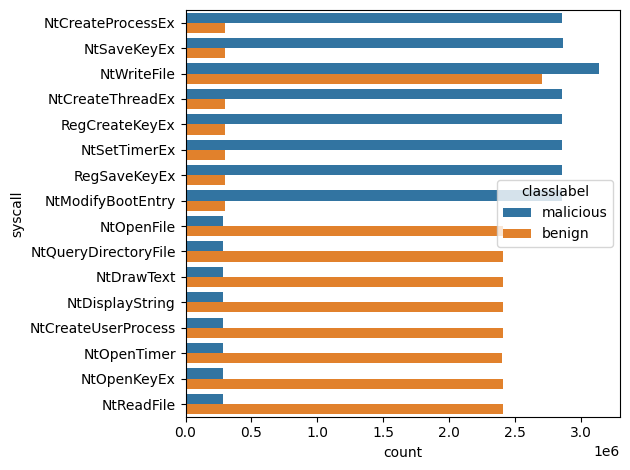

In [29]:
# Get counts for each trace
mal_counts = Counter()
for path in maltraces:
    with open(path) as f:
        trace = f.read()
        mal_counts += frequency(trace)

ben_counts = Counter()
for path in bentraces:
    with open(path) as f:
        trace = f.read()
        ben_counts += frequency(trace)

# Build DataFrame
mal_syscalls, mal_freq = zip(*mal_counts.items())
ben_syscalls, ben_freq = zip(*ben_counts.items())
df = pd.concat([pd.DataFrame({'syscall': mal_syscalls, 'count': mal_freq, 'classlabel': 'malicious'}),
                pd.DataFrame({'syscall': ben_syscalls, 'count': ben_freq, 'classlabel': 'benign'})])

# Plot it!
p = seaborn.barplot(x='count', y='syscall', hue='classlabel', data=df)
plt.tight_layout()
plt.show()

Notice how different the frequencies are between malicious and benign execution traces! Which one of the system calls occurs in roughly the same number of benign and malicious traces? If you wanted to make your malware appear to be benign, which system calls would you inject? Post you answers in Group Chat!

It is important to note a few things:
* This example is synthetic. It's unlikely the differences will be this extreme!
* This is _not_ directly related to the model we are attacking!

How can we better understand what the _model_ believes are system calls that indicate malicious vs. benign behavior? Let's dig into the classifier's _coefficients_ and its terms. Defined above are `clf.coef_` and `terms`, which show the model's coefficients for each system call, respectively. The 0th coefficient corresponds to the 0th terms, etc., so let's examine these directly:

In [30]:
sorted(list(zip(clf.coef_[0], terms)))

[(-2.144622087973717, 'ntreadfile'),
 (-2.1418627669686754, 'ntcreateuserprocess'),
 (-2.14075679846129, 'ntquerydirectoryfile'),
 (-2.1405272962289374, 'ntdrawtext'),
 (-2.139671958251064, 'ntdisplaystring'),
 (-2.139654749547881, 'ntopenfile'),
 (-2.138546391661048, 'ntopenkeyex'),
 (-2.138453274413692, 'ntopentimer'),
 (0.10771154443371536, 'ntwritefile'),
 (2.242767946060603, 'ntsettimerex'),
 (2.2431060978323165, 'regsavekeyex'),
 (2.2442406107176405, 'ntcreatethreadex'),
 (2.244822624665083, 'ntcreateprocessex'),
 (2.245233313408202, 'ntmodifybootentry'),
 (2.246132957843823, 'ntsavekeyex'),
 (2.2480150712142497, 'regcreatekeyex')]

How do these values correspond to the counts we saw in the previous plot? If you were trying to make a malicious binary appear benign, which system calls would you force you malware to call? Why? Post your thoughts in Group Chat!

## Indirect Attack Part 2 (Adversarial Sample Generation)

Based on what we learned above, modify the `gen_adversarial_sample` function below to have `syscall` default to one that is more associated with benign traces than malicious traces.

In [31]:
def gen_adversarial_sample(path, syscall='ntreadfile'): # TODO: Change to 'ntwritefile' in notebook
    with open(path) as f:
        s = f.read()
        numsyscalls = len(s.split())
        s_benign = s + '\n' + '\n'.join(itertools.repeat(syscall, numsyscalls))
        return s, s_benign

In [33]:
s, s_benign = gen_adversarial_sample('malicious-traces/0999.trace')
print(len(s))
print(len(s_benign))

186656
326543


In [34]:
# It works!
clf.predict(vectorizer.transform([s, s_benign]))

array([1, 0])

In [35]:
orig = []
mutated = []
for maltrace in maltraces:
    mal, adv = gen_adversarial_sample(maltrace)
    malvec = vectorizer.transform([mal])
    advvec = vectorizer.transform([adv])
    orig.append(clf.predict(malvec))
    mutated.append(clf.predict(advvec))
print(Counter([x[0] for x in orig]))
print(Counter([x[0] for x in mutated]))

Counter({1: 1000})
Counter({0: 1000})


Not only does it work on a single example, but it breaks everything we saw in the ground truth! Some questions:

* Why was the default syscall `'ntwritefile'`?
* Describe how `gen_adversarial_sample` works. How would you defend against this if this was one of your models?

Post you answers to Group Chat!

## Extra Credit: Make Classifier Monotonic

A simple way to make a classifier monotonic for our purposes is to not allow attackers to abuse negative coefficient features. Add a vector to `clf.coef` such that there are no longer negative coefficients, and demonstrates this defeats your adversarial generation function from the previous exercise.

We can accomplish this by:
* Identify the index in `clf.coef_` for the feature you abused
* Set its weight to `0.0`
* Rerunning our classification examples from above

In [36]:
clf.coef_[0][clf.coef_.argmin()] = 0.0

In [37]:
maltraces, bentraces = gettraces()
orig = []
mutated = []
benign = []
for maltrace in maltraces:
    mal, adv = gen_adversarial_sample(maltrace)
    malvec = vectorizer.transform([mal])
    advvec = vectorizer.transform([adv])
    orig.append(clf.predict(malvec))
    mutated.append(clf.predict(advvec))
print('Original malicious traces')
print(Counter([x[0] for x in orig]))
print('Adversarial malicious traces')
print(Counter([x[0] for x in mutated]))

# What about the benign examples?
for bentrace in bentraces:
    benvec = get_feature_vector(bentrace, vectorizer)
    benign.append(clf.predict(benvec))
print('Original benign traces')
print(Counter([x[0] for x in benign]))

Original malicious traces
Counter({1: 1000})
Adversarial malicious traces
Counter({1: 1000})
Original benign traces
Counter({0: 1000})


So it works, but we more or less nullified the utility of the feature aside from its interactions with other variables when constructing the model. Sometimes keeping this is desirable, but it could suggest that this feature provides more drawbacks than benefits. This further demonstrates the importance of feature engineering: if the features are useful, but when known can be weaponized by attackers, perhaps it is better to sacrifice accuracy in order to have more resilient models.